# Coursework 2

## Preliminaries

* Prepare and clean data 
* Standardise descriptors

In [117]:
import pandas as pd
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

np.random.seed(0)

In [118]:
data = pd.read_csv('train_set.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)
data

test_data = pd.read_csv('test_set.csv')
test_data.drop('Unnamed: 0', axis=1, inplace=True)

In [119]:
encode = {
    'low':0, 'small':0, 'unacc':0,
    'med':1, 'acc':1,
    'high':2, 'big':2, 'good':2,
    'vhigh':3, 'vgood': 3,
    '5more': 5, 'more':5
}

for c in list(data.columns):
    data[c] = data[c].apply(lambda x: encode[x] if len(str(x)) > 1 else x)
    test_data[c] = test_data[c].apply(lambda x: encode[x] if len(str(x)) > 1 else x)
test_data

,buying,maint,doors,persons,lug_boot,safety,rating
0,1,0,3,4,0,1,1
1,0,0,2,5,2,1,2
2,3,3,2,2,0,1,2
3,0,0,2,5,2,1,0
4,3,3,2,2,0,1,0
...,...,...,...,...,...,...,...
987,0,0,4,2,1,2,0
988,0,0,4,4,1,0,0
989,0,0,5,2,1,2,0
990,0,0,5,2,2,2,0


In [120]:
rating_counts = data.rating.value_counts()
min_no = min(rating_counts)

df_0 = data[data['rating'] == 0].sample(min_no).reset_index().drop(columns=['index'])
df_1 = data[data['rating'] == 1].sample(min_no).reset_index().drop(columns=['index'])
df_2 = data[data['rating'] == 2].sample(min_no).reset_index().drop(columns=['index'])
df_3 = data[data['rating'] == 3].sample(min_no).reset_index().drop(columns=['index'])

print(len(df_0), len(df_1), len(df_2), len(df_3))
data = pd.concat([df_0, df_1, df_2, df_3]).reset_index(drop=True)
data

851 851 851 851


,buying,maint,doors,persons,lug_boot,safety,rating
0,0,0,4,5,0,2,0
1,3,2,3,2,0,1,0
2,2,2,5,5,2,2,0
3,3,1,4,2,2,1,0
4,0,3,3,4,2,0,0
...,...,...,...,...,...,...,...
3399,0,2,2,5,2,2,3
3400,3,3,5,2,0,2,3
3401,3,3,3,4,2,2,3
3402,0,0,5,4,1,2,3


In [121]:
attributes = list(data.columns)[:-1]
print(attributes)
y = data['rating'].reset_index(drop=True)
X = pd.DataFrame(preprocessing.scale(data[attributes]), columns=(attributes))

y_test = test_data['rating'].reset_index(drop=True)
X_test = pd.DataFrame(preprocessing.scale(test_data[attributes]), columns=(attributes))

['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']


## **Task 1**
**Train a random forest classifier on the training set to optimise the accuracy of your validation predictions using 5-fold stratified cross validation. You should use the 5-fold cross validation to explore and optimise over suitable ranges the following hyperparameters: (i) number of decision trees; (ii) depth of trees, (iii) maximum number of descriptors (features) randomly chosen at each split.**

Note: Although other measures of performance, such as precision, recall, etc, could (and should) be used for comparison, here we only concentrate on accuracy for simplicity. Explain and document your choice for the best RF model. Explain which of the hyperparameters have a bigger impact on performance. Base your answer on computations and explain in relation to the mathematical basis of the algorithm.

In [7]:


no_trees = np.linspace(start=1, stop=200, num=20, dtype=np.int64)
depths = list(np.linspace(start=1, stop=20, num=5, dtype=np.int64))
depths.append(None)
max_no_descriptors = [1, 2, 3, 4, 5, 6]
param_grid = {
    'n_estimators': no_trees,
    'max_depth': depths,
    'max_features': max_no_descriptors
}

In [8]:
rf = RandomForestClassifier()

best_rf = GridSearchCV(rf, param_grid, n_jobs=-1, cv=5, verbose=2)
best_rf.fit(X,y)

print("best params: ", best_rf.best_params_)
print("best acc: ", best_rf.best_score_)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed:  1.5min


best params:  {'max_depth': 5, 'max_features': 2, 'n_estimators': 21}
best acc:  0.36427732079905994


[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed:  1.7min finished


## **Task 2**
**Train a support vector machine (SVM) on your training data using three different kernel functions: (i) linear; (ii) polynomial, (iii) RBF. Each of those kernels have a few hyperparameters which you should explore and tune using 5-fold cross validation to find the kernel (and hyperparameters) with the highest validation accuracy. Explain and document your choice for the best SVM model (kernel and hyperparameters) for our data. Base your answer on computations and give explanations related to the mathematical basis of the algorithm**

C is the penalty parameter of the error term. It controls the trade off between smooth decision boundary and classifying the training points correctly.
gamma is a parameter for non linear hyperplanes. The higher the gamma value it tries to exactly fit the training data set
degree is a parameter used when kernel is set to ‘poly’. It’s basically the degree of the polynomial used to find the hyperplane to split the data.Using degree=1 is the same as using a ‘linear’ kernel

How much tolerance(soft) we want to give when finding the decision boundary is an important hyper-parameter for the SVM (both linear and nonlinear solutions). In Sklearn, it is represented as the penalty term — ‘C’. The bigger the C, the more penalty SVM gets when it makes misclassification. Therefore, the narrower the margin is and fewer support vectors the decision boundary will depend on.

What Kernel Trick does is it utilizes existing features, applies some transformations, and creates new features. Those new features are the key for SVM to find the nonlinear decision boundary.

In Sklearn — svm.SVC(), we can choose ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ or a callable as our kernel/transformation.


Think of the Radial Basis Function kernel as a transformer/processor to generate new features by measuring the distance between all other dots to a specific dot/dots — centers. The most popular/basic RBF kernel is the Gaussian Radial Basis Function:

gamma (γ) controls the influence of new features — Φ(x, center) on the decision boundary. The higher the gamma, the more influence of the features will have on the decision boundary, more wiggling the boundary will be (overfit).

    the higher the C, the more penalty SVM was given when it misclassified, and therefore the less wiggling the decision boundary will be
    the higher the gamma, the more influence the feature data points will have on the decision boundary, thereby the more wiggling the boundary will be

In [239]:
cs = [0.001, 0.01, 0.1, 1, 10, 100, 200]
gammas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
#coef_zeroes = []
# shrinking = [True, False]
sv = SVC()

linear_grid = {
    'kernel': ['linear'],
    'C': cs
}

poly_grid = {
    'kernel': ['poly'],
    'C': cs,
    'degree': [1,2,3,4],
    'gamma': gammas
}

rbf_grid = {
    'kernel': ['rbf'],
    'C': cs,
    'gamma': gammas
}

In [ ]:
for g in [linear_grid, poly_grid, rbf_grid]:
    best_svm = GridSearchCV(sv, g, n_jobs=-1, cv=5, verbose=1)
    best_svm.fit(X,y)
    ker = g['kernel'][0]
    print(ker)
    print("best params: ", best_svm.best_params_)
    print("best acc: ", best_svm.best_score_)
    print(f'##############################\n')

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   20.9s finished


linear
best params:  {'C': 100, 'kernel': 'linear'}
best acc:  0.3495887191539365
##############################

Fitting 5 folds for each of 196 candidates, totalling 980 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   13.4s


## **Task 3**
**In Task 3, you will explore how a feed-forward neural network performs on the training set. Using Pytorch, train a neural network to classify each car in the training set based on the given descriptors. Setup of the network: Your network should have two hidden layers, each with 200 neurons. You should use ReLU as your activation function. Fix the optimisation method to be stochastic gradient descent (SGD), and define the loss function as cross-entropy. You should train on batches of 64 data points with a learning rate of 0.01 for 120 epochs.**


In [148]:
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F

In [123]:
# prepare data
X_train = torch.from_numpy(X.values).float()
y_train = torch.from_numpy(y.values)
X_test = torch.from_numpy(X_test.values).float()
y_test = torch.from_numpy(y_test.values)

In [142]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(p=dropout)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = self.dropout(out)
        out = F.relu(self.fc3(out))
        out = self.fc4(out)
        return out

In [164]:
def train_net(net, optimiser, criterion, train_loader, num_epochs):
    loss_values = []
    steps = len(train_loader)

    for epoch in range(num_epochs):

        net.train()
        train_loss = 0.0

        for batch_X, batch_y in train_loader:
            # forward pass
            outputs = net(batch_X)
            loss = criterion(outputs, batch_y)

            # backward and optimise
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            train_loss += loss.item()

        loss_values.append(train_loss /steps)
    return loss_values
    
    
def train_analysis(learning_rate=0.01, batch_size = 64, num_classes=4, input_size = 6, hidden_size = 200, num_epochs=120, dropout=0, graph=True):

    train = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size)

    test = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size)
    
    #Create
    net = NeuralNet(input_size, hidden_size, num_classes, dropout)
    criterion = nn.CrossEntropyLoss()
    optimiser = torch.optim.SGD(net.parameters(), lr=learning_rate) 
    
    loss_values = train_net(net, optimiser, criterion, train_loader, num_epochs)
    
    if graph:
        plt.figure(figsize=(12,8))
        plt.ylabel('Training Loss', fontsize=20)
        plt.xlabel('Epoch', fontsize=20)
        plt.plot(range(len(loss_values)), loss_values)
    return net

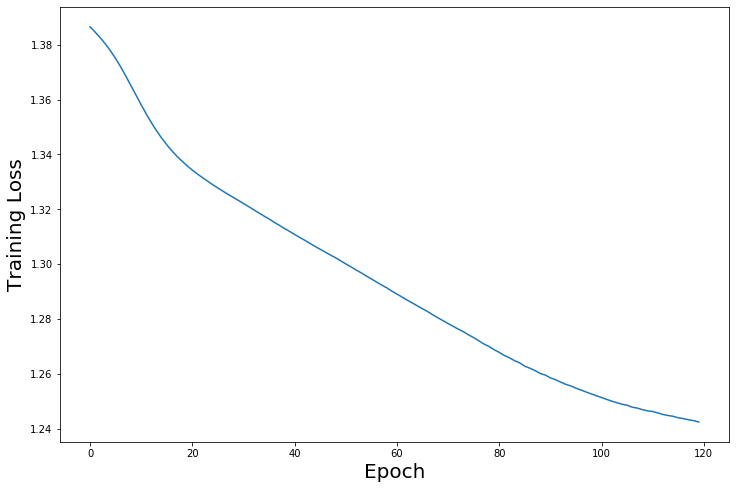

In [151]:
loss_analysis = train_analysis()

### **3.1** 
**Show and document how changing the learning rate to: (i) 0.0005 and (ii) 0.95 leads to poor convergence.**

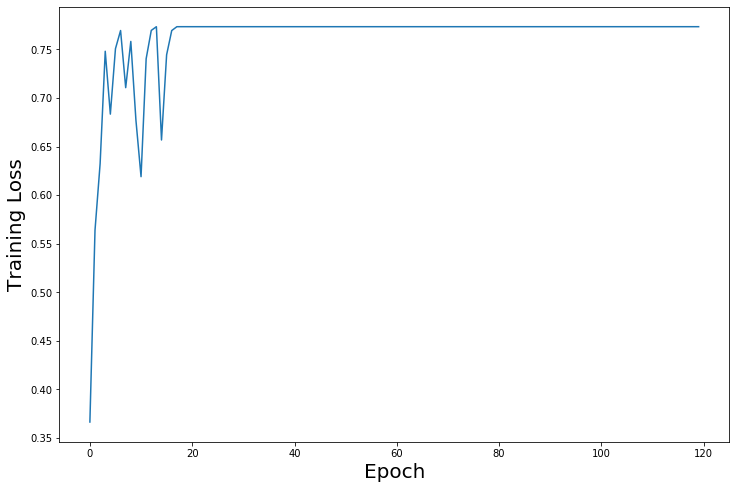

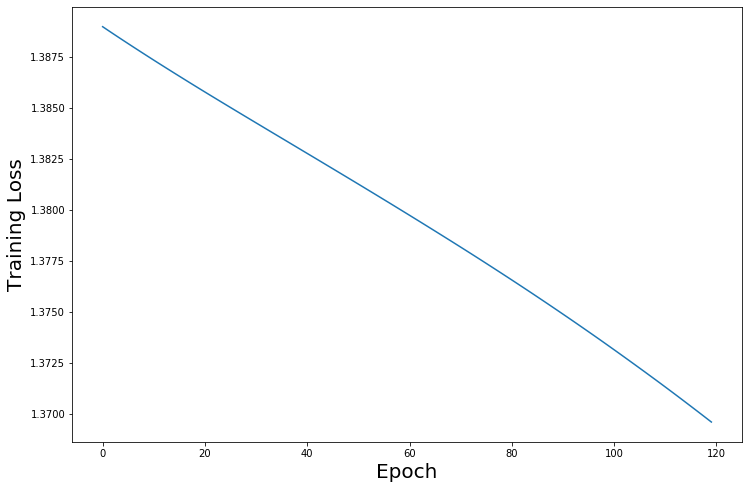

In [156]:
loss_analysis = train_analysis(learning_rate=0.95)
loss_analysis = train_analysis(learning_rate=0.0005)

### **3.2**
**Show and document how changing the batch size to: (i) 2 and (ii) 256 leads to poor convergence
and performance. Explain the reasons.**

This took 108.6401264667511s


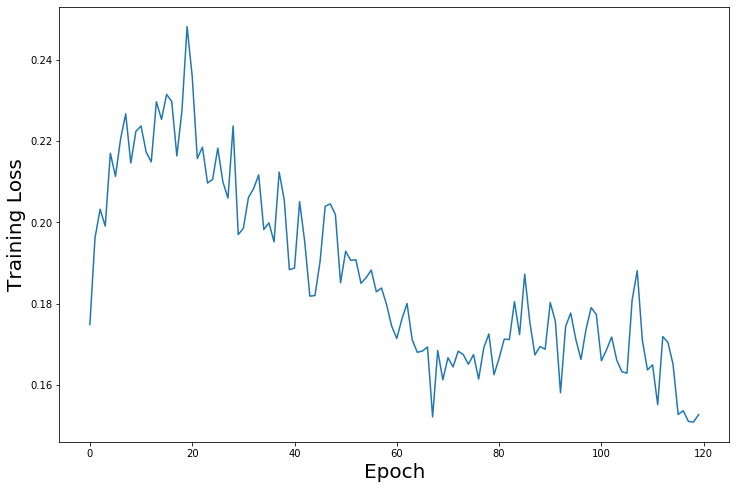

In [200]:
import time

start = time.time()
loss_analysis = train_analysis(batch_size=2)
print(f'This took {time.time()-start}s')

This took 4.1421449184417725s


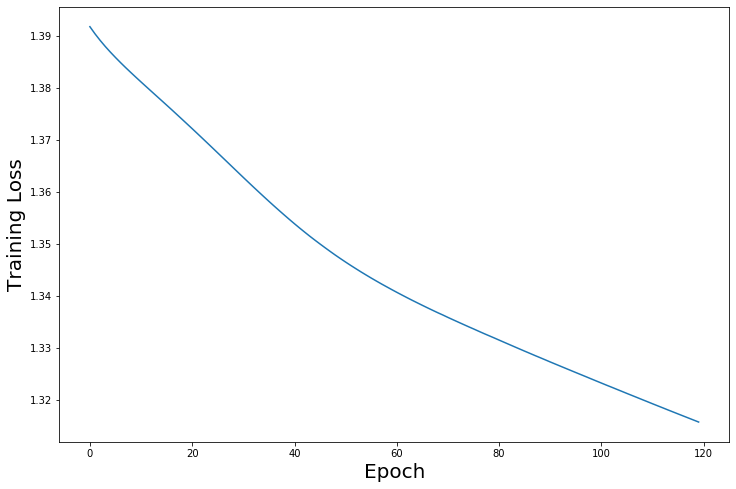

In [201]:
start = time.time()
loss_analysis = train_analysis(batch_size=256)
print(f'This took {time.time()-start}s')

### **3.3**
**In Pytorch, implement dropout regularisation to the second layer of the NN, and tune the dropoutrate to optmise the validation accuracy of the NN.**

0.39314516129032256
0.3951612903225806
0.4012096774193548
0.39919354838709675
0.3971774193548387
0.39818548387096775
0.4032258064516129
0.39818548387096775
0.4002016129032258
0.3901209677419355
0.3911290322580645
0.38306451612903225
0.3941532258064516
0.3961693548387097
0.3901209677419355
0.3901209677419355
0.38205645161290325
0.3911290322580645
0.3840725806451613
0.38205645161290325
0.3810483870967742
0.38205645161290325
0.38205645161290325
0.3497983870967742
0.2862903225806452


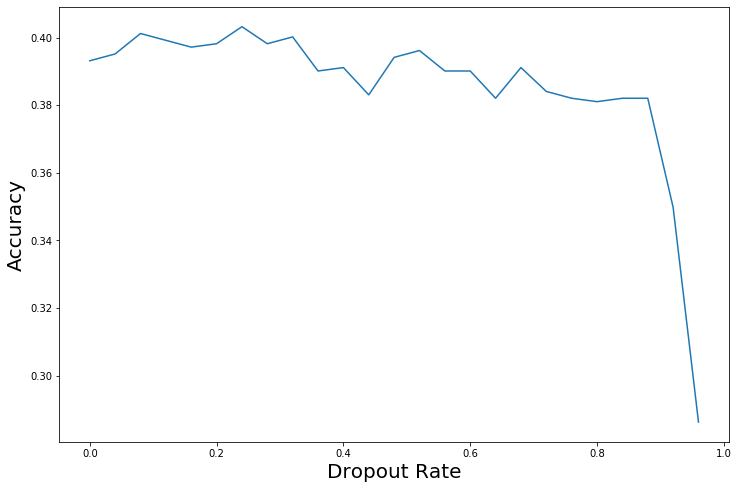

In [190]:
dropouts = np.linspace(0, 1, num=25, endpoint=False)
accuracies = []

for d in (dropouts):
    net = train_analysis(dropout=d, graph=False)
    net.eval()

    correct = 0
    total = 0
    for Xs, ys in test_loader:
        outputs = net(Xs)
        _, predicted = torch.max(outputs.data, 1)
        total += ys.size(0)
        correct += (predicted == ys).sum().item()
    accuracies.append(correct/total)
    
plt.figure(figsize=(12,8))
plt.ylabel('Accuracy', fontsize=20)
plt.xlabel('Dropout Rate', fontsize=20)
plt.plot(dropouts, accuracies)

**Explain and document your choice for the best NN model (dropout rate) for the given architecture basing your answer on computations and on explanations related to the mathematical basis of the algorithm.**

## **Task 4**
### **4.1** 
***Compare the performance of the three classifiers you have obtained in Tasks 1, 2 and 3 by applying them to the test data set. You should report the accuracy, recall, precision, and F1 score and any other relevant score derived from the confusion matrix. Examine your results in relation to the performance obtained for the training set.***

### **4.2** 
**Discuss the suitability of each of the three methods for our task. Comment on their generalizability to the test data, computational cost, and the appropriateness given the dimensionality of the data and any other insights based on your study of the descriptors of the data set. You should base your evaluations on evidence and computations.**

## **Task 5**

### **5.1** 
**(20 marks) Consider the NN model you implemented in Task 3. Optimise a new NN where the architecture is changed to have 5 hidden layers with 80 neurons each. Compare the performance of this 'deep' network to the 'shallow' network in Task 3 in terms of performance, training and computational cost. Feel free to provide additional evidence and computations to support your analysis.**



### **5.2** 
**(5 marks) Consider the NN model you implemented in Task 3. Optimise a NN with the same architecture as in Task 3 but changing the activation units from ReLU to Sigmoidal. Compare the performance of the ReLU and sigmoidal NNs and, specifically, their speed of convergence.**